# How to get card info

Need to install the sdk: pip install pokemontcgsdk

To find the id for a card, look in https://pokemontcg.guru/

In [6]:
# setup
from pokemontcgsdk import Card
from pokemontcgsdk import RestClient
RestClient.configure('c0a13e31-4371-413c-8f1f-264697acc48e')  # my API key

In [19]:
# get one card
card = Card.find('xy1-146')
print(card.name)
print(card.tcgplayer.prices.normal)
print(card.tcgplayer.prices.holofoil.market)
print(card.cardmarket)  # currency in euros

Xerneas-EX
None
39.34
Cardmarket(url='https://prices.pokemontcg.io/cardmarket/xy1-146', updatedAt='2025/03/15', prices=CardmarketPrices(averageSellPrice=29.63, lowPrice=7.49, trendPrice=27.04, germanProLow=0.0, suggestedPrice=0.0, reverseHoloSell=0.0, reverseHoloLow=40.0, reverseHoloTrend=24.59, lowPriceExPlus=19.99, avg1=48.48, avg7=27.54, avg30=23.03, reverseHoloAvg1=9.9, reverseHoloAvg7=18.25, reverseHoloAvg30=17.3))


# YOLOv11 for Instance Segmentation
I trained a model to detect pokemon cards, but it only detects cards in general. We still have to identify which card it is.

Need to install ultralytics: pip install ultralytics

In [32]:
from ultralytics import YOLO

# Load a COCO-pretrained YOLO11n model
model = YOLO("yolo11n-seg.pt")  # load an official model
model = YOLO('yolo11n_seg_best_10epochs.pt')  # build from weights

In [33]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
img = cv2.imread("test2.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
results = model(img)  # predict on an image
for result in results:
    bboxs = result.boxes.xywh.data.numpy()  # Boxes object for bounding box outputs
    masks = (result.masks.data.numpy() * 255).astype("uint8")  # Masks object for segmentation masks outputs
    keypoints = result.keypoints  # Keypoints object for pose outputs
    probs = result.probs  # Probs object for classification outputs
    obb = result.obb  # Oriented boxes object for OBB outputs
    result.show()  # display to screen




0: 480x640 7 cards, 121.3ms
Speed: 6.0ms preprocess, 121.3ms inference, 8.0ms postprocess per image at shape (1, 3, 480, 640)


In [30]:
# we need to resize the output to get the masked pixels

from PIL import Image

def get_bbox_corner(bbox, img):
    x, y, w, h = bbox
    x_min = int(x - w / 2)
    y_min = int(y - h / 2)
    x_max = int(x + w / 2)
    y_max = int(y + h / 2)

    height, width, _ = img.shape
    x_min = max(0, x_min)
    y_min = max(0, y_min)
    x_max = min(width, x_max)
    y_max = min(height, y_max)

    return x_min, y_min, x_max, y_max


def get_segmented_card(mask, bbox, img):
    resized_mask = cv2.resize(mask, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_NEAREST)
    
    # get masked pixels
    cutout = resized_mask[..., None]*img

    # Get bounding box coordinates (x, y, width, height, conf, label)
    x_min, y_min, x_max, y_max = get_bbox_corner(bbox, img)

    # Crop to bounding box
    cropped_cutout = cutout[y_min:y_max, x_min:x_max]

    # Convert to PIL image
    cropped_cutout = Image.fromarray((cropped_cutout * 255).astype(np.uint8))

    return cropped_cutout


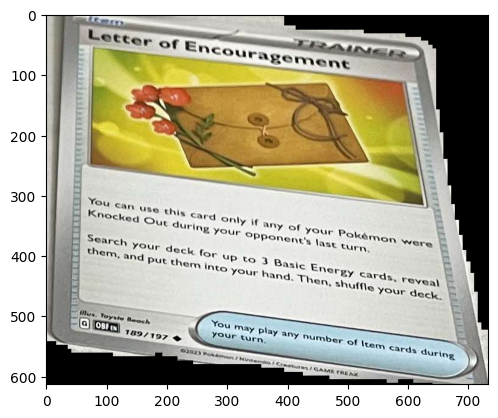

In [31]:
mask = masks[0]
bbox = bboxs[0]

cropped_cutout = get_segmented_card(mask, bbox, img)

plt.imshow(cropped_cutout)
plt.show()